# Summative Lab: NLP, Time Series, & Neural Networks- Analytics Firm Clients

## Part 1: Natural Language Processing

### Imports and Data

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter


# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')


# For dataset loading
from sklearn.datasets import fetch_20newsgroups


# Set random seed for reproducibility
np.random.seed(42)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sbail\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sbail\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sbail\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sbail\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sbail\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sbail\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_pe

In [5]:


# Load a subset of the 20 Newsgroups dataset
categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, random_state=42)


# Create a DataFrame for easier manipulation
df = pd.DataFrame({
   'text': newsgroups.data,
   'category': [newsgroups.target_names[target] for target in newsgroups.target]
})


# Preview the data
print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nSample document:")
print(df['text'][10][:500])  # Print first 500 characters of a sample document

Dataset shape: (2236, 2)

Category distribution:
category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample document:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden


In [8]:
df.head()

,text,category
0,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,comp.graphics
1,From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...,talk.politics.misc
2,From: rick@trystro.uucp (Richard Nickle)\nSubj...,sci.space
3,From: marshatt@feserve.cc.purdue.edu (Zauberer...,rec.autos
4,From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...,talk.politics.misc


### Text cleaning and Tokenization

In [11]:
""" Convert text to lowercase, remove punctuation, and handle potential numerical or URL patterns."""
# Define a dictionary of common abbreviations/contractions
abbreviation_map = {
    "don't": "do not",
    "can't": "cannot",
    "won't": "will not",
    "i'm": "i am",
    "it's": "it is",
    "you're": "you are",
    "they're": "they are",
    "we're": "we are",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "doesn't": "does not",
    "didn't": "did not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "mustn't": "must not",
    "let's": "let us",
    "that's": "that is",
    "what's": "what is",
    "there's": "there is",
    "who's": "who is",
    "she's": "she is",
    "he's": "he is",
    "it'll": "it will",
    "i'll": "i will",
    "you'll": "you will",
    "we'll": "we will",
    "they'll": "they will",
    "i'd": "i would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "i've": "i have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "who've": "who have"
    # Add more as needed
}


In [13]:
# Remove email addresses (including those in angle brackets)
def remove_emails(text):
    return re.sub(r'<?[\w\.-]+@[\w\.-]+>?', '', text)

# Remove common email header words
def remove_email_header(text):
    email_headers = [
        'subject', 're', 'fwd', 'from', 'to', 'cc', 'bcc', 'sent', 'forwarded', 'organization', 'date'
    ]
    pattern = r'\b(?:' + '|'.join(email_headers) + r')\b'
    return re.sub(pattern, '', text, flags=re.IGNORECASE)

# Remove quoted reply lines (lines starting with '>')
def remove_quoted_lines(text):
    return '\n'.join([line for line in text.split('\n') if not line.strip().startswith('>')])

# Remove signatures (everything after a line with just '--')
def remove_signature(text):
    return text.split('\n--\n')[0]

# Remove URLs and file paths
def remove_urls_paths(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'/\S+', '', text)
    return text

# Expand abbreviations/contractions
def expand_abbreviations(text, abbreviation_map):
    for abbr, full in abbreviation_map.items():
        text = re.sub(r'\b' + re.escape(abbr) + r'\b', full, text)
    return text
    
def remove_email_headers_block(text):
    # List of common email header fields (add more as needed)
    header_fields = [
        'From', 'Subject', 'Organization', 'Lines', 'Distribution', 'Reply-To',
        'NNTP-Posting-Host', 'Date', 'Path', 'Message-ID', 'References', 'Sender',
        'In-Reply-To', 'X-Newsreader', 'X-Mailer', 'X-Posted-From', 'X-Originating-IP'
    ]
    # Regex pattern to match lines starting with any header field followed by ':'
    pattern = r'^(?:' + '|'.join(header_fields) + r')\:.*(?:\n|$)'
    # Remove all such lines (re.MULTILINE for ^ to match start of each line)
    return re.sub(pattern, '', text, flags=re.MULTILINE)

def remove_proper_nouns(tokens):
    """
    Remove tokens that are proper nouns (NNP, NNPS) from a list of tokens.
    """
    tagged = pos_tag(tokens)
    return [token for token, tag in tagged if tag not in ('NNP', 'NNPS')]
def remove_filler_sequences(text):
    # Remove sequences like 'blah blah', 'blah blah blah', etc.
    return re.sub(r'(blah\s+)+', '', text, flags=re.IGNORECASE)



In [15]:
def expand_abbreviations(text, abbreviation_map):
    # Replace abbreviations in the text string
    for abbr, full in abbreviation_map.items():
        # Use regex for word boundaries to avoid partial matches
        text = re.sub(r'\b' + re.escape(abbr) + r'\b', full, text)
    return text
def clean_text(text_tokens):
    """
    Clean raw text by:
    1. Converting to lowercase
    2. Removing HTML tags if present
    3. Removing email addresses, email header words, US state names, and 'usa'
    4. Removing special characters, numbers, and underscores
    """
    # List of US state names (lowercase, no spaces)
    us_states = {
        'alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado', 'connecticut', 'delaware',
        'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky',
        'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi',
        'missouri', 'montana', 'nebraska', 'nevada', 'newhampshire', 'newjersey', 'newmexico',
        'newyork', 'northcarolina', 'northdakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania',
        'rhodeisland', 'southcarolina', 'southdakota', 'tennessee', 'texas', 'utah', 'vermont',
        'virginia', 'washington', 'westvirginia', 'wisconsin', 'wyoming'
    }

    tokens = [token.lower() for token in text_tokens]
    cleaned = []
    for token in tokens:
        # Remove HTML tags
        token = re.sub(r'<.*?>', '', token)
        # Remove email addresses
        token = re.sub(r'[\w\.-]+@[\w\.-]+', '', token)
        # Remove URLs
        token = re.sub(r'http\S+|www\S+', '', token)
        # Remove special characters, numbers, and underscores
        cleansed = re.sub(r'[^a-zA-Z\s]', '', token)
        # Remove single-character tokens except 'i' and 'a'
        if len(cleansed) == 1 and cleansed not in {'i', 'a'}:
            continue
        if not cleansed or cleansed.isspace():
            continue
        # Remove 'usa'
        if cleansed == 'usa':
            continue
        # Remove US state names (remove spaces for matching)
        if cleansed.replace(' ', '') in us_states:
            continue
        cleaned.append(cleansed)
    return cleaned

In [17]:
# Apply all cleansing steps in order
def full_cleanse(text):
    text = remove_emails(text)
    text = remove_email_header(text)
    text = remove_quoted_lines(text)
    text = remove_signature(text)
    text = remove_urls_paths(text)
    text = expand_abbreviations(text, abbreviation_map)
    return text

# Apply the full cleansing pipeline
df['no_headers_text'] = df['text'].apply(remove_email_headers_block)
df['clean_text'] = df['no_headers_text'].apply(full_cleanse)
# Apply before tokenization
df['no_filler_text'] = df['clean_text'].apply(remove_filler_sequences)

# Tokenize and further clean as before
df['sentences'] = df['no_filler_text'].apply(sent_tokenize)
df['tokens'] = df['no_filler_text'].apply(word_tokenize)
df['no_names_tokens'] = df['tokens'].apply(remove_proper_nouns)
df['clean_tokens'] = df['no_names_tokens'].apply(clean_text)

In [18]:
# Assign the count of unique word tokens across all reviews
all_tokens = []
for tokens in df['clean_tokens']:
    all_tokens.extend(tokens)
unique_token_count_pre = len(set(all_tokens))
print("\nUnique Number of Tokens:")
print(unique_token_count_pre)


Unique Number of Tokens:
20534


### Stopword removal and Lemmatization

In [22]:
# Get English stopwords as a set
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(tokens):
    """
    Remove stopwords from a list of tokens
    
    Parameters:
    tokens (list): List of word tokens
    
    Returns:
    list: Tokens with stopwords removed
    """
    custom_stopwords = set(stopwords.words('english')).union({'would', 'could', 'should'})
    
    return [token for token in tokens if token not in custom_stopwords]


# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    """
    Convert NLTK POS tags to WordNet POS tags
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatization function
def lemmatize_tokens(tokens):
    """
    Lemmatize tokens with appropriate POS tags
    
    Parameters:
    tokens (list): List of word tokens
    
    Returns:
    list: Lemmatized tokens
    """
    # Tag tokens with parts of speech
    tokens_tagged = pos_tag(tokens)
    
    # Convert to WordNet POS tags
    pos_tokens = [(token, get_wordnet_pos(tag)) for token, tag in tokens_tagged]
    
    # Lemmatize with POS tags
    lemmatized = [lemmatizer.lemmatize(token, pos) for token, pos in pos_tokens]
    
    return lemmatized

# Apply custom stopword removal
df['filtered_tokens'] = df['clean_tokens'].apply(remove_stopwords)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization
df['lemmatized_tokens'] = df['filtered_tokens'].apply(lemmatize_tokens)

In [23]:
# Calculate stopword reduction percentage
# Assign the count of unique word tokens across all reviews after cleaning and normalizing
all_tokens = []
for tokens in df['lemmatized_tokens']:
    all_tokens.extend(tokens)
unique_token_count_post = len(set(all_tokens))
stopword_reduction_percent = ((unique_token_count_pre - unique_token_count_post) / unique_token_count_pre) * 100

In [28]:
# Check results on the sample review
sample_idx = 15
print("Tokens after stopword removal (first 15):")
print(df['filtered_tokens'][sample_idx][:15])
print(df['filtered_tokens'][sample_idx])
print("\nTokens after lemmatization (first 15):")
print(df['lemmatized_tokens'][sample_idx][:15])
print(df['lemmatized_tokens'][sample_idx])
print(f"\nRemoving stopwords and lemmatizing the text has reduced the vocaburlary by {stopword_reduction_percent:.2f}%")

Tokens after stopword removal (first 15):
['article', 'writes', 'suggest', 'take', 'car', 'nearest', 'dealer', 'oil', 'filter', 'oil', 'change', 'cost', 'less', 'watch', 'watching']
['article', 'writes', 'suggest', 'take', 'car', 'nearest', 'dealer', 'oil', 'filter', 'oil', 'change', 'cost', 'less', 'watch', 'watching', 'someone', 'job', 'able', 'learn', 'remember', 'sequence', 'right', 'next', 'time', 'besides', 'loosens', 'drain', 'nut', 'next', 'time', 'around', 'easier', 'stuck', 'use', 'impact', 'wrench', 'much', 'force', 'though', 'use', 'new', 'washer', 'time', 'put', 'nut', 'back']

Tokens after lemmatization (first 15):
['article', 'write', 'suggest', 'take', 'car', 'near', 'dealer', 'oil', 'filter', 'oil', 'change', 'cost', 'less', 'watch', 'watch']
['article', 'write', 'suggest', 'take', 'car', 'near', 'dealer', 'oil', 'filter', 'oil', 'change', 'cost', 'less', 'watch', 'watch', 'someone', 'job', 'able', 'learn', 'remember', 'sequence', 'right', 'next', 'time', 'besides', 'l

In [30]:
# Analyze the impact of stopword removal
original_count = len(df['clean_tokens'][sample_idx])
filtered_count = len(df['filtered_tokens'][sample_idx])
reduction_percent = ((original_count - filtered_count) / original_count) * 100

print(f"\nStopword removal reduced token count from {original_count} to {filtered_count} ({reduction_percent:.1f}% reduction)")


Stopword removal reduced token count from 100 to 46 (54.0% reduction)


In [32]:
# Function to generate bigrams and trigrams
def generate_ngrams(tokens, n):
    """
    Generate n-grams from a list of tokens
    
    Parameters:
    tokens (list): List of tokens
    n (int): Size of n-grams to generate
    
    Returns:
    list: List of n-grams as tuples
    """
    result = {}
    for i in n:
        result[f'{i}-grams'] = list(ngrams(tokens, i))
    return result

# Generate bigrams and trigrams - hint - apply lamdba function
df['bigrams'] = df['lemmatized_tokens'].apply(lambda x: generate_ngrams(x, [2]))
df['trigrams'] = df['lemmatized_tokens'].apply(lambda x: generate_ngrams(x, [3]))

# Combine all lemmatized tokens into a single list for frequency analysis
all_tokens = []
for tokens in df['lemmatized_tokens']:
    all_tokens.extend(tokens)

# Calculate all token frequencies
token_freq = Counter(all_tokens)

# Get all bigrams for frequency analysis
all_bigrams = []
for bigrams in df['bigrams']:
    #all_bigrams.extend(bigrams)
    all_bigrams.extend(bigrams['2-grams'])

# Calculate bigram frequencies
bigram_freq = Counter(all_bigrams)

# Get all trigrams for frequency analysis
all_trigrams = []
for trigrams in df['trigrams']:
    #all_trigrams.extend(trigrams)
    all_trigrams.extend(trigrams['3-grams'])
# Calculate trigram frequencies
trigram_freq = Counter(all_trigrams)

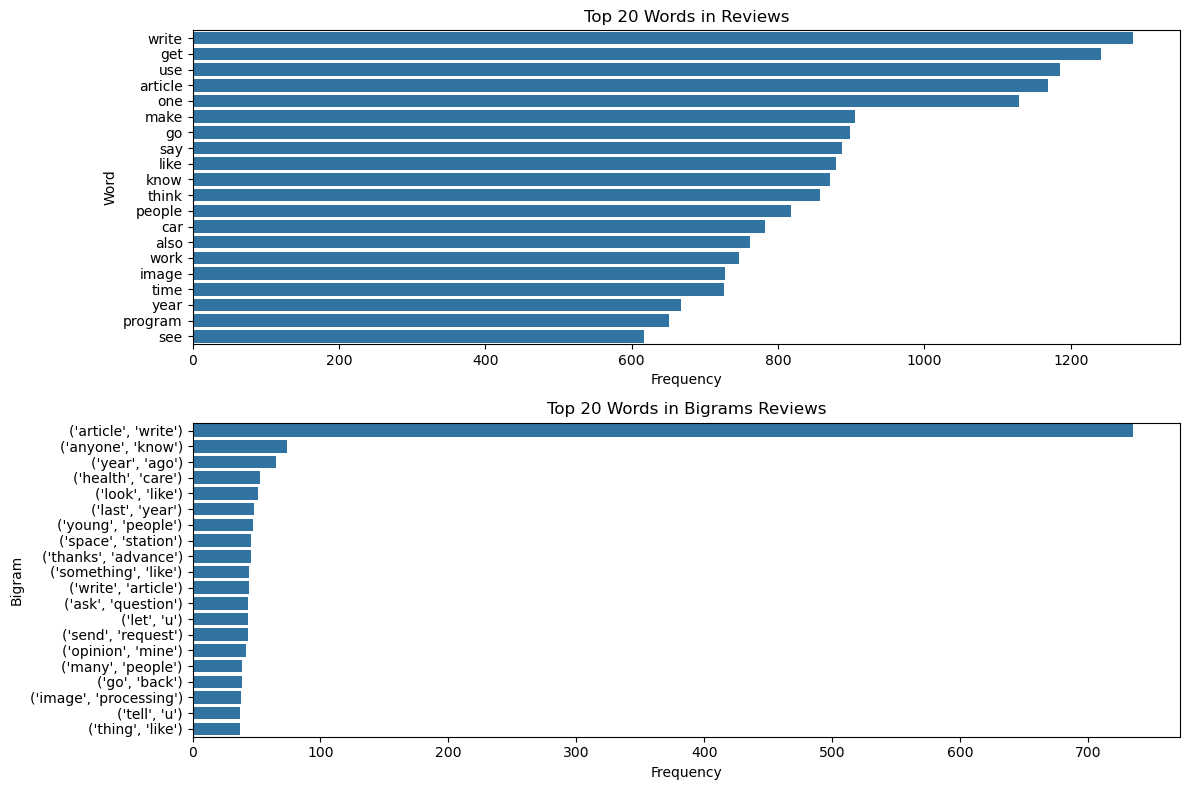

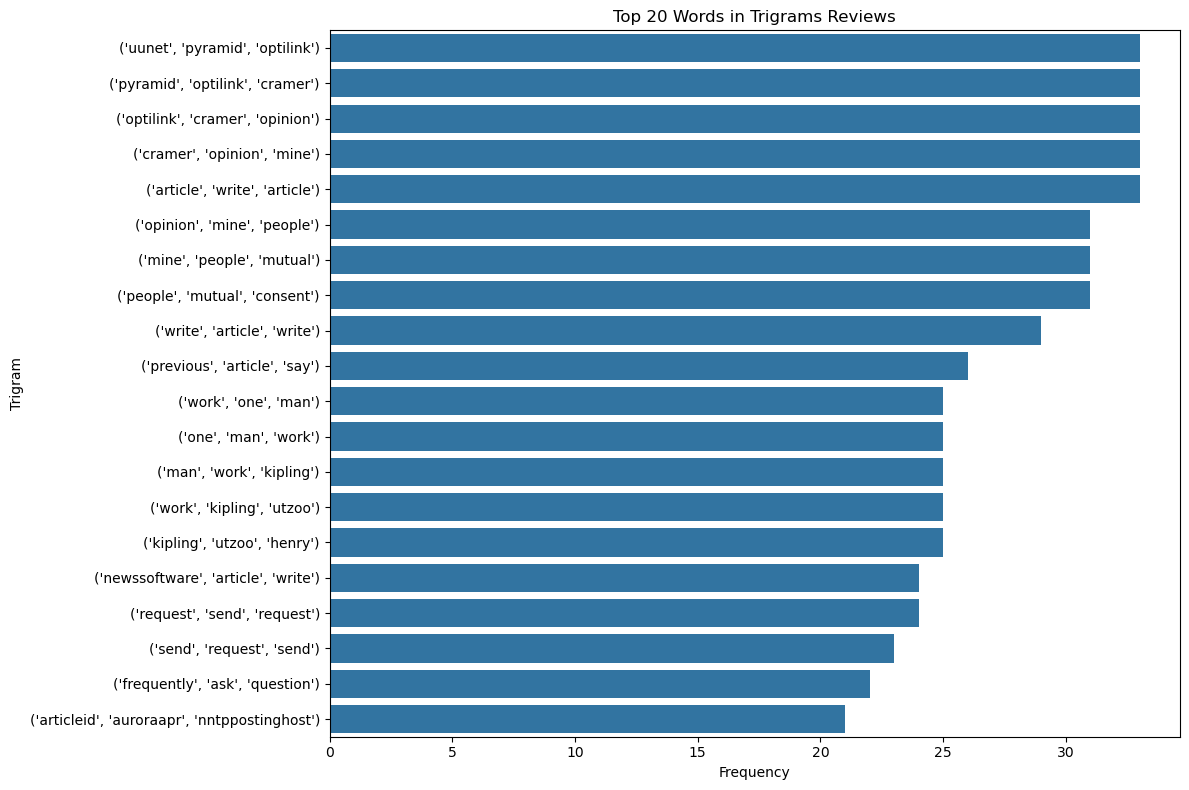

In [34]:

# Visualize top tokens and bigrams
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
## token_freq.plot(20, title="Top 20 Words in Reviews")
words, counts = zip(*token_freq.most_common(20))
sns.barplot(x=list(counts), y=list(words), orient='h')
plt.title("Top 20 Words in Reviews")
plt.xlabel("Frequency")
plt.ylabel("Word")

plt.subplot(2, 1, 2)
##bigram_freq.plot(20, title="Top 20 Bigrams in Reviews")
top_bigrams = bigram_freq.most_common(20)
bigram_labels = [bigram for bigram, count in top_bigrams]
bigram_counts = [count for bigram, count in top_bigrams]
sns.barplot(x=bigram_counts, y=[str(bigram) for bigram in bigram_labels], orient='h')
plt.title("Top 20 Words in Bigrams Reviews")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.tight_layout()

# Visualize top trigrams
plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)
top_trigrams = trigram_freq.most_common(20)
trigram_labels = [trigram for trigram, count in top_trigrams]
trigram_counts = [count for trigram, count in top_trigrams]
sns.barplot(x=trigram_counts, y=[str(trigram) for trigram in trigram_labels], orient='h')
plt.title("Top 20 Words in Trigrams Reviews")
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.tight_layout()
plt.show()

### Conclusion

In [38]:
# Define keywords for each category
category_keywords = {
    'comp.graphics': ['graphics', 'image', 'file', 'driver', 'format', 'card', 'display', 'render','write','send','ball'],
    'rec.autos': ['car', 'engine', 'oil', 'drive', 'tire', 'brake', 'vehicle', 'auto', 'speed'],
    'sci.space': ['nasa','space', 'shuttle', 'orbit', 'launch', 'nasa', 'moon', 'mission', 'astronaut','optilink','frequently','kipling'],
    'talk.politics.misc': ['government', 'policy', 'political', 'law', 'vote', 'president', 'congress', 'tax','opinion','people','say','man','nntppostinghost']
}

def assign_category(trigram, category_keywords):
    trigram_str = ' '.join(trigram)
    for category, keywords in category_keywords.items():
        if any(word in trigram_str for word in keywords):
            return category
    return 'Other'

# Print top trigrams with suggested categories
print("Top Trigrams and Suggested Categories:")
for trigram, count in trigram_freq.most_common(20):
    category = assign_category(trigram, category_keywords)
    print(f"{' '.join(trigram):40} | {count:4d} | {category}")

Top Trigrams and Suggested Categories:
uunet pyramid optilink                   |   33 | sci.space
pyramid optilink cramer                  |   33 | sci.space
optilink cramer opinion                  |   33 | sci.space
cramer opinion mine                      |   33 | talk.politics.misc
article write article                    |   33 | comp.graphics
opinion mine people                      |   31 | talk.politics.misc
mine people mutual                       |   31 | talk.politics.misc
people mutual consent                    |   31 | talk.politics.misc
write article write                      |   29 | comp.graphics
previous article say                     |   26 | talk.politics.misc
work one man                             |   25 | talk.politics.misc
one man work                             |   25 | talk.politics.misc
man work kipling                         |   25 | sci.space
work kipling utzoo                       |   25 | sci.space
kipling utzoo henry                      |   25 | 

In [40]:
from collections import Counter

# Create a dictionary to hold trigram frequencies per category
category_trigram_freq = {}

for category in df['category'].unique():
    # Get all trigrams for this category
    trigrams_in_category = []
    for trigrams in df[df['category'] == category]['trigrams']:
        trigrams_in_category.extend(trigrams['3-grams'])
    # Count frequency
    category_trigram_freq[category] = Counter(trigrams_in_category)

# Example: Print top 10 trigrams for each category
for category, trigram_counter in category_trigram_freq.items():
    print(f"\nTop trigrams for category: {category}")
    for trigram, count in trigram_counter.most_common(10):
        print(f"{trigram}: {count}")


Top trigrams for category: comp.graphics
('vertex', 'vertex', 'vertex'): 14
('week', 'per', 'group'): 11
('px', 'px', 'py'): 11
('px', 'py', 'py'): 11
('py', 'py', 'pz'): 11
('py', 'pz', 'pz'): 11
('row', 'oprows', 'col'): 11
('oprows', 'col', 'opcols'): 11
('value', 'value', 'value'): 11
('den', 'px', 'px'): 10

Top trigrams for category: talk.politics.misc
('uunet', 'pyramid', 'optilink'): 33
('pyramid', 'optilink', 'cramer'): 33
('optilink', 'cramer', 'opinion'): 33
('cramer', 'opinion', 'mine'): 33
('opinion', 'mine', 'people'): 31
('mine', 'people', 'mutual'): 31
('people', 'mutual', 'consent'): 31
('nntppostinghost', 'thoriscbrcom', 'article'): 14
('thoriscbrcom', 'article', 'write'): 13
('nntppostinghost', 'magnusugmagnusacsohiostateedu', 'article'): 12

Top trigrams for category: sci.space
('work', 'one', 'man'): 25
('one', 'man', 'work'): 25
('man', 'work', 'kipling'): 25
('work', 'kipling', 'utzoo'): 25
('kipling', 'utzoo', 'henry'): 25
('articleid', 'auroraapr', 'nntppostin

In [42]:
# Count the number of trigrams in each document and sum by category
df['num_trigrams'] = df['trigrams'].apply(lambda x: len(x['3-grams']))

# Group by category and sum the trigram counts
trigram_count_by_category = df.groupby('category')['num_trigrams'].sum()

print(trigram_count_by_category)

category
comp.graphics         38663
rec.autos             33452
sci.space             54241
talk.politics.misc    53267
Name: num_trigrams, dtype: int64


#### Notes
This Python code performs comprehensive text preprocessing and analysis on a subset of the 20 Newsgroups dataset. Here’s a summary of its main steps:

1. Data Loading & Setup
* Loads four categories from the 20 Newsgroups dataset into a pandas DataFrame.
* Sets up necessary imports and downloads NLTK resources.

2. Text Cleansing Functions
* Defines functions to remove email addresses, headers, quoted lines, signatures, URLs, and file paths.
* Expands common abbreviations/contractions.
* Cleans tokens by removing HTML, numbers, special characters, US state names, "usa", and single-character tokens (except "i" and "a").

3. Text Preprocessing Pipeline
* Applies all cleansing steps to the raw text.
* Tokenizes sentences and words.
* Normalizes tokens and tracks modifications.
* Removes stopwords (with custom additions like "would", "could", "should").
* Lemmatizes tokens using POS tagging.

4. N-gram Generation
* Generates bigrams and trigrams from lemmatized tokens.
* Calculates frequency counts for tokens, bigrams, and trigrams.
* Analysis & Visualization

5. Prints sample documents and token modifications.
* Calculates and prints vocabulary reduction after stopword removal and lemmatization.
* Visualizes the top 20 most frequent tokens, bigrams, and trigrams using bar plots.

In summary:
The code cleans and normalizes text data, removes noise, generates n-grams, and visualizes the most common words and phrases to help understand domain-specific language usage in the selected newsgroup categories.


# Part 2: Time Series Forecasting

## Imports and Data

In [47]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings


# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


# Set plotting style
sns.set_theme()


# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


In [48]:
# Display the first few rows of the dataset
print("S&P 500 Dataset:")
print(sp500.head())


# Display basic information about the dataset
print("\nDataset information:")
print(sp500.info())


# Calculate basic summary statistics
print("\nSummary Statistics:")
print(sp500['Close'].describe())


# Check for missing values
print("\nMissing values in each column:")
print(sp500.isnull().sum())

S&P 500 Dataset:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2013-01-02  1462.420044  1462.430054  1426.189941  1426.189941  4202600000
2013-01-03  1459.369995  1465.469971  1455.530029  1462.420044  3829730000
2013-01-04  1466.469971  1467.939941  1458.989990  1459.369995  3424290000
2013-01-07  1461.890015  1466.469971  1456.619995  1466.469971  3304970000
2013-01-08  1457.150024  1461.890015  1451.640015  1461.890015  3601600000

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2518 non-null   float64
 1   (High, ^GSPC)    2518 non-null   float64
 2   (Low, ^GSPC)     2518 non-null   float64
 3   (O

## Visualization

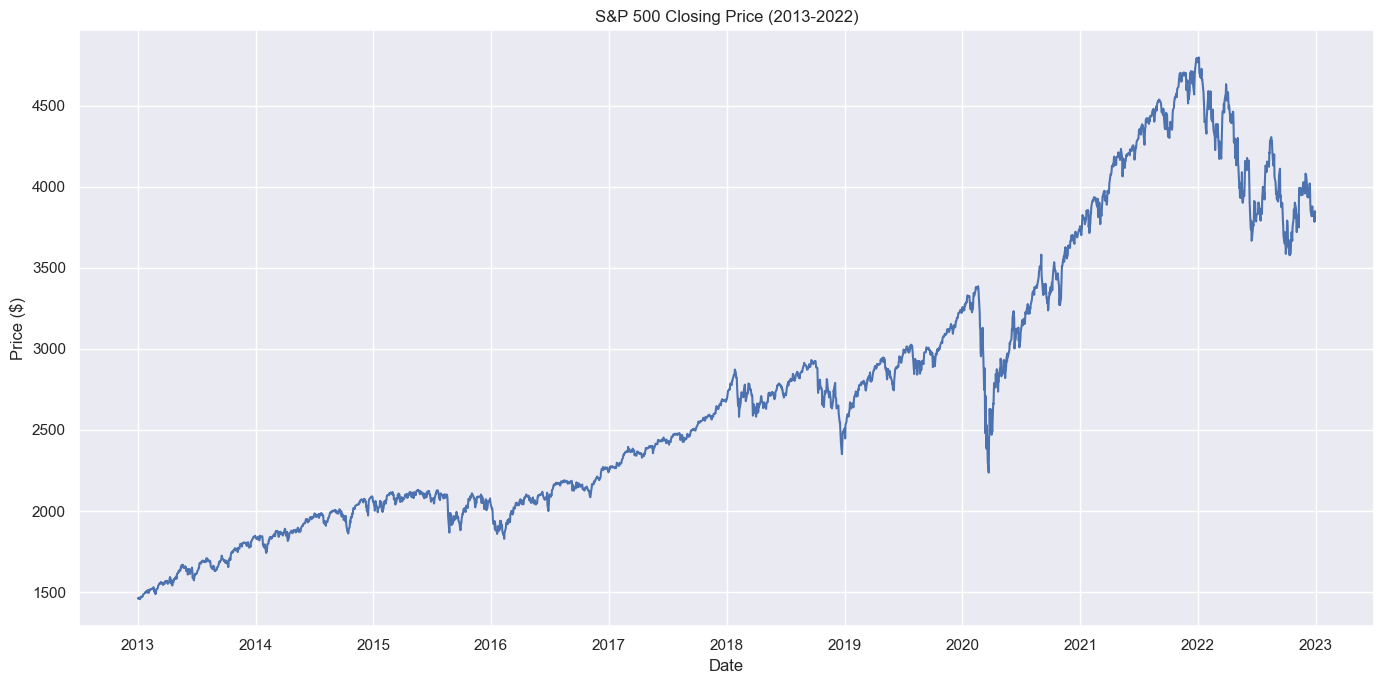


Selected time series shape: (2518, 1)


In [53]:
# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(sp500.index, sp500['Close'])
plt.title('S&P 500 Closing Price (2013-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']
print("\nSelected time series shape:", ts_data.shape)

In [55]:
# Calculate rolling mean and standard deviation
rolling_mean = ts_data.rolling(window=30).mean()
rolling_std = ts_data.rolling(window=30).std()

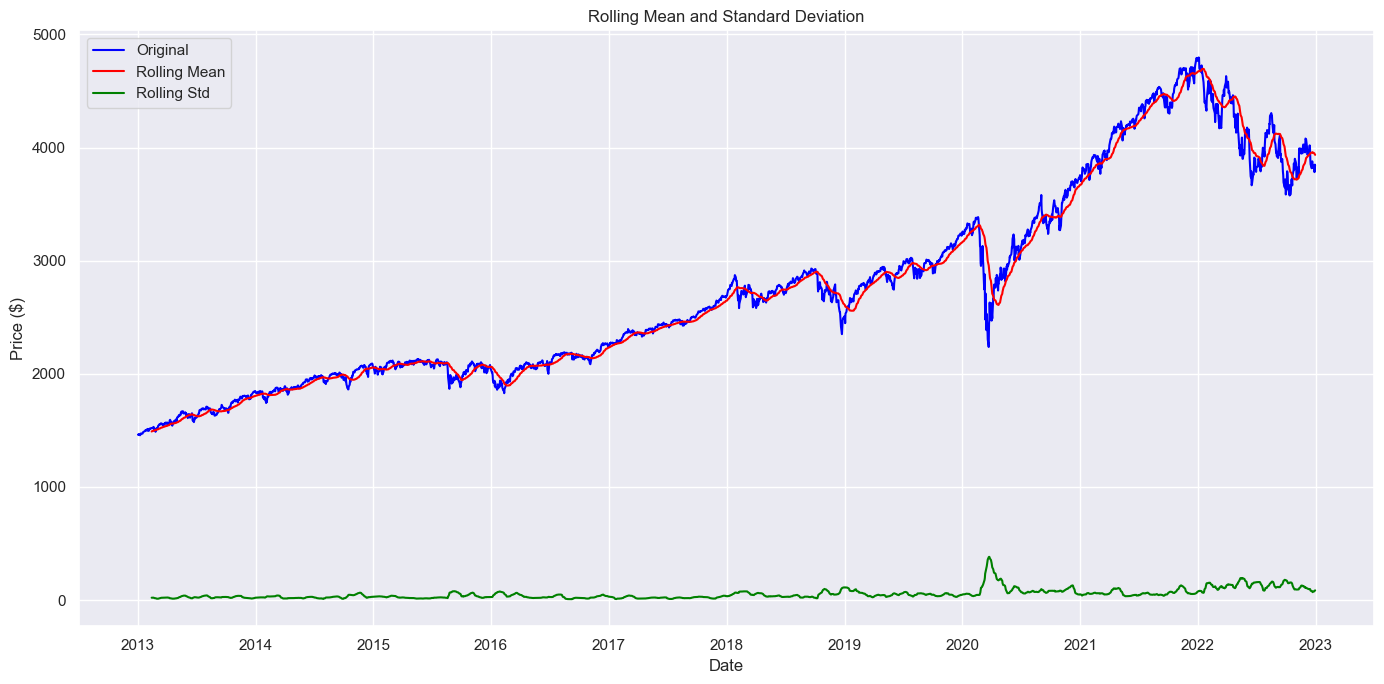

In [57]:
# Plot rolling statistics
plt.figure(figsize=(14, 7))
plt.plot(ts_data, label='Original', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## ADF

In [60]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(ts_data.dropna())
print("\nAugmented Dickey-Fuller Test Result:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("The time series is stationary (reject null hypothesis).")
# Crtical values for ADF test
print("\nCritical Values:")
print(adf_result[4])


Augmented Dickey-Fuller Test Result:
ADF Statistic: -1.0312090768619346
p-value: 0.7417120357643825

Critical Values:
{'1%': -3.4329610922579095, '5%': -2.8626935681060375, '10%': -2.567384088736619}


Analysis: 
The ADF Statistic (-1.0312) is not more negative than any of the standard critical values. And the p-value (0.7417) is greater than common significance levels (like 0.01, 0.05, or 0.10). The data is non stationary



In [63]:
# Transform the time series to make it stationary if necessary
if adf_result[1] >= 0.05:
    # Differencing the time series
    ts_data_diff = ts_data.diff().dropna()
    # Re-run the ADF test on the differenced series
    adf_result_diff = adfuller(ts_data_diff)
    print("\nAugmented Dickey-Fuller Test Result on Differenced Series:")
    print(f"ADF Statistic: {adf_result_diff[0]}")
    print(f"p-value: {adf_result_diff[1]}")
    if adf_result_diff[1] < 0.05:
        print("The differenced time series is stationary (reject null hypothesis).")
    else:
        print("The differenced time series is non-stationary (fail to reject null hypothesis).")
  


Augmented Dickey-Fuller Test Result on Differenced Series:
ADF Statistic: -15.87572923675591
p-value: 8.875471555829325e-29
The differenced time series is stationary (reject null hypothesis).


Notes:

The initial time series I tested was non-stationary. By "differencing" it (which usually means subtracting the previous observation from the current one, I have successfully transformed it into a stationary series. This is a common and necessary step in time series analysis, especially when preparing data for ARIMA models, which require stationarity.

## Decomposition

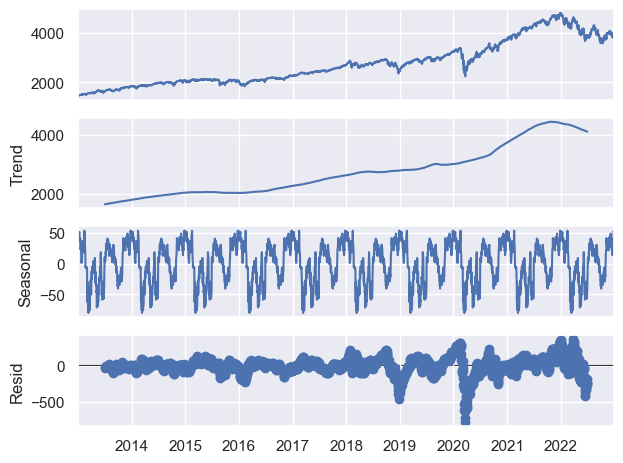

In [67]:
# Decompose the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(ts_data, model='additive', period=252)  # 252 trading days in a year
decomposition.plot()
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

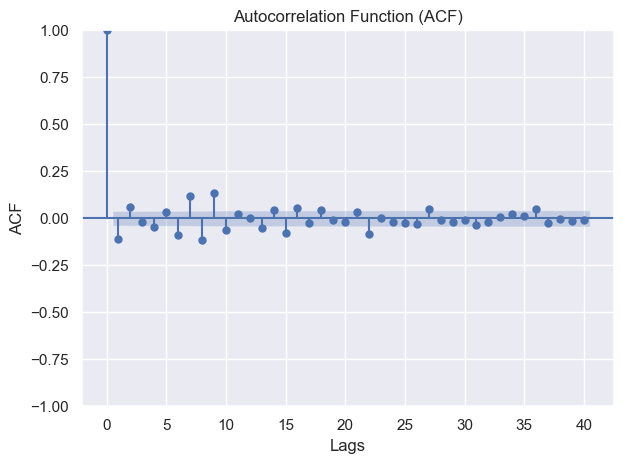

<Figure size 1400x700 with 0 Axes>

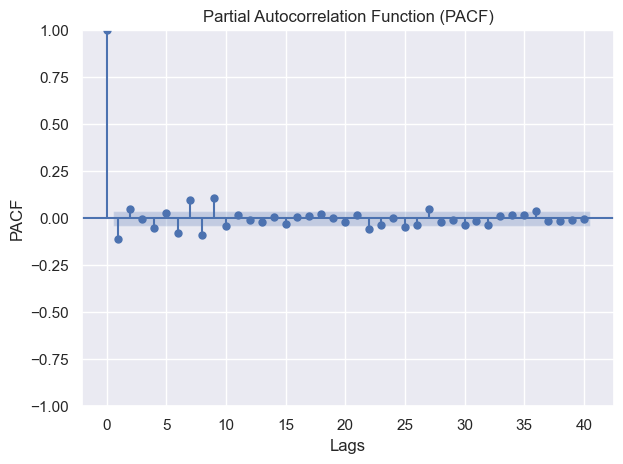

In [69]:
# Plot ACF and PACF to identify potential AR and MA terms
plt.figure(figsize=(14, 7))
plot_acf(ts_data_diff, lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 7))
plot_pacf(ts_data_diff, lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Selection

In [72]:
# Fit an ARIMA model (p=1, d=1, q=1) as an example
model = ARIMA(ts_data, order=(1, 1, 1))
# Fit the model
model_fit = model.fit()
# Print the model summary
print("\nARIMA Model Summary:")
print(model_fit.summary())


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2518
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12388.323
Date:                Tue, 17 Jun 2025   AIC                          24782.647
Time:                        10:53:46   BIC                          24800.139
Sample:                             0   HQIC                         24788.995
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3846      0.062     -6.198      0.000      -0.506      -0.263
ma.L1          0.2759      0.065      4.221      0.000       0.148       0.404
sigma2      1104.1869     13.0

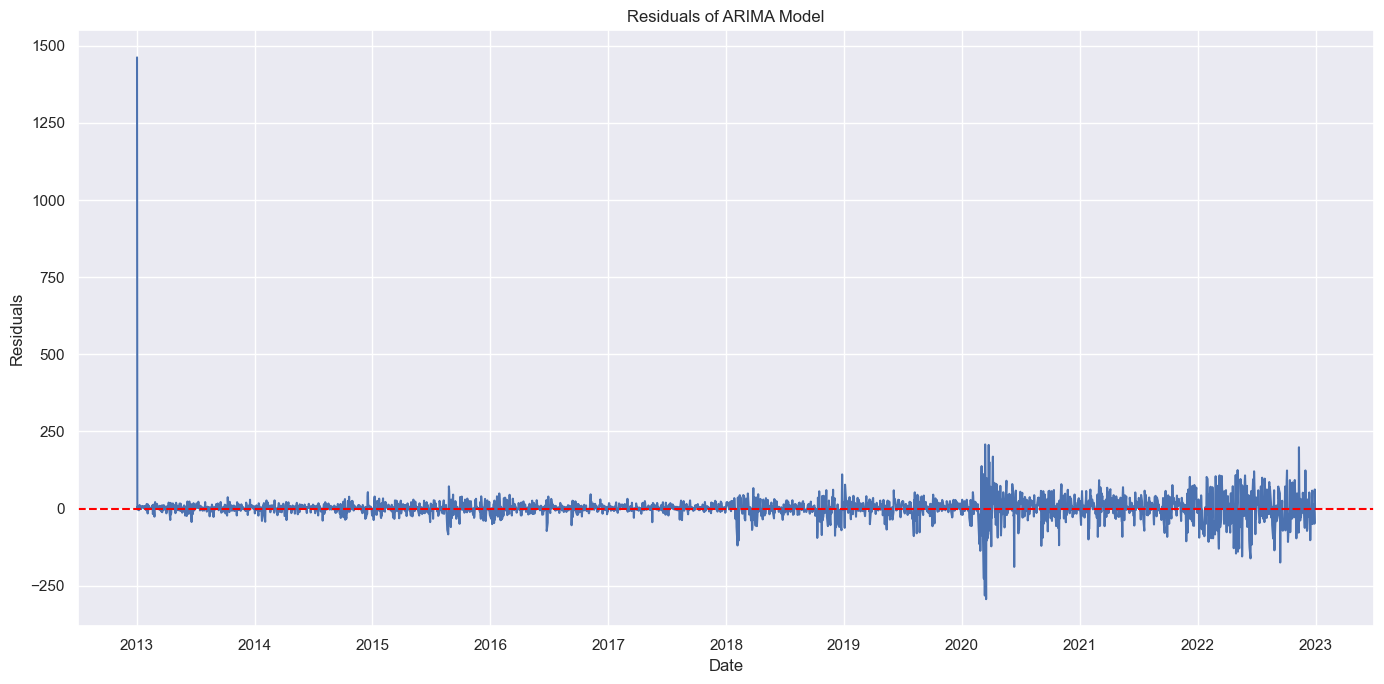

<Figure size 1400x700 with 0 Axes>

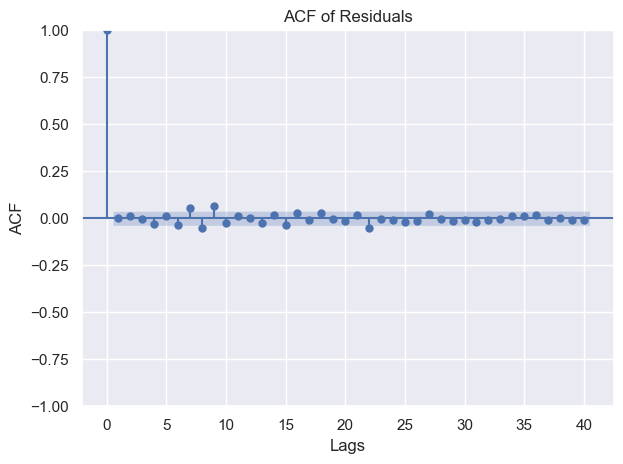

<Figure size 1400x700 with 0 Axes>

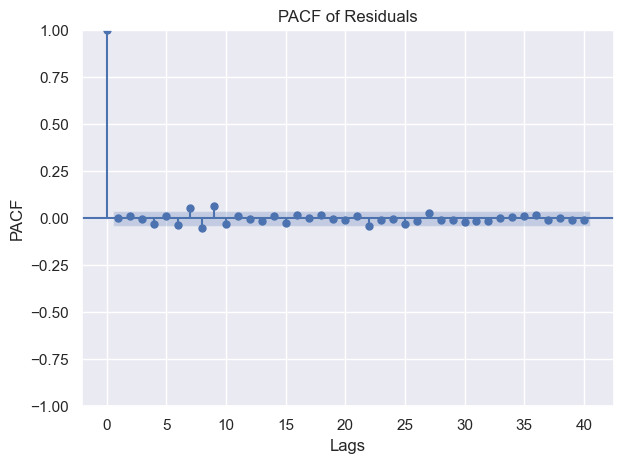

In [74]:
# Plot the residuals of the model
residuals = model_fit.resid
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()
# Plot ACF and PACF of residuals to check for autocorrelation
plt.figure(figsize=(14, 7))
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 7))
plot_pacf(residuals, lags=40)
plt.title('PACF of Residuals')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
# Fit a second ARIMA model (p=2, d=1, q=2) as an example
model2 = ARIMA(ts_data, order=(2, 1, 2))
# Fit the second model
model_fit2 = model2.fit()
# Print the second model summary
print("\nARIMA Model 2 Summary:")
print(model_fit2.summary())


ARIMA Model 2 Summary:
                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2518
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12341.139
Date:                Tue, 17 Jun 2025   AIC                          24692.277
Time:                        10:53:50   BIC                          24721.431
Sample:                             0   HQIC                         24702.858
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7543      0.016   -112.553      0.000      -1.785      -1.724
ar.L2         -0.8808      0.015    -60.495      0.000      -0.909      -0.852
ma.L1          1.6750      0

In [78]:
# Compare AIC and BIC of both models
print("\nModel Comparison:")
print(f"Model 1 AIC: {model_fit.aic}, BIC: {model_fit.bic}")
print(f"Model 2 AIC: {model_fit2.aic}, BIC: {model_fit2.bic}")
# Based on AIC/BIC, choose the best model (lower is better)
best_model = model_fit if model_fit.aic < model_fit2.aic else model_fit2
# Print the best model summary
print("\nBest Model Summary:")
print(best_model.summary())


Model Comparison:
Model 1 AIC: 24782.646765947804, BIC: 24800.13923493321
Model 2 AIC: 24692.277116561843, BIC: 24721.43123153752

Best Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2518
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12341.139
Date:                Tue, 17 Jun 2025   AIC                          24692.277
Time:                        10:53:51   BIC                          24721.431
Sample:                             0   HQIC                         24702.858
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7543      0.016   -112.553      0.000    

## Forecast

In [81]:
# Forecasting with the best model
# Forecasting the next 30 days using the best model
# Ensure the best model is fitted
if 'best_model' not in locals():
    best_model = model_fit  # Fallback to the first model if no better model was found
forecast = best_model.get_forecast(steps=30)
# Get the forecasted values and confidence intervals
forecasted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [83]:
# evaluate prediction accuracy (MAE, RMSE, MAPE)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split data: train on all except last 30 days, test on last 30 days
train = ts_data[:-30]
test = ts_data[-30:]

# Fit model on train
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# Forecast the next 30 days (same dates as test)
forecast = model_fit.get_forecast(steps=30)
forecasted_values = forecast.predicted_mean

mae = mean_absolute_error(test.values, forecasted_values.values)
rmse = np.sqrt(mean_squared_error(test.values, forecasted_values.values))
mape = np.mean(np.abs((test.values - forecasted_values.values) / test.values)) * 100

# Print the accuracy metrics
print("\nPrediction Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Prediction Accuracy Metrics:
Mean Absolute Error (MAE): 73.77
Root Mean Squared Error (RMSE): 90.90
Mean Absolute Percentage Error (MAPE): 1.88%


## Conclusion
1. Mean Absolute Error (MAE): 73.77: On average, this model's predictions are off by approximately 73.77 points from the actual S&P 500 values.
2. Root Mean Squared Error (RMSE): 90.90: This model's predictions typically deviate from the actual values by about 90.90 points.
3. Mean Absolute Percentage Error (MAPE): 1.88%: On average, this model's predictions deviate from the actual values by 1.88%.

A MAPE of 1.88% for a volatile financial index like the S&P 500 is generally considered quite good for a simple ARIMA model. This suggests my model is capturing a substantial amount of the underlying patterns and trends.

# Part 3: Neural Networks

## Imports and Data

In [553]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.datasets import load_digits


# For deep learning
import tensorflow as tf
from tensorflow import keras
from keras import layers


# For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)


# Load Digits dataset for classification
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

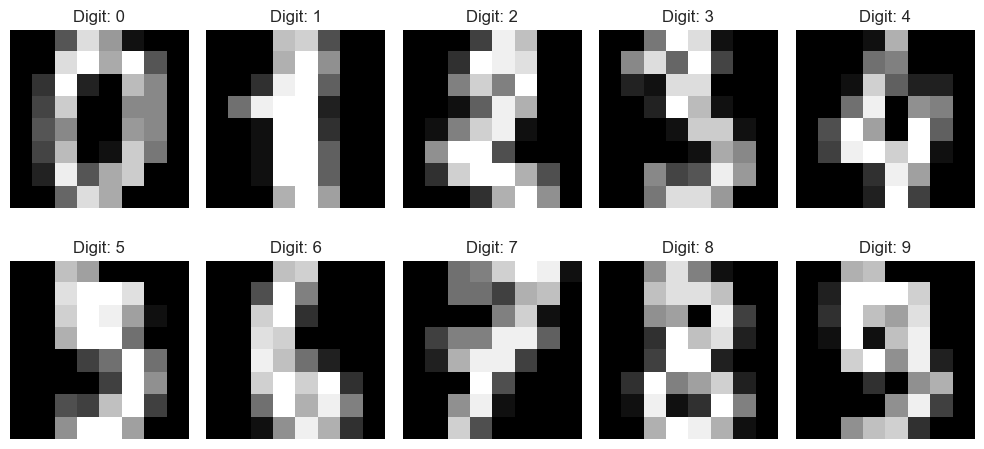

Digits dataset: 1797 samples, 64 features


In [555]:
# Display sample digits
plt.figure(figsize=(10, 5))
for i in range(10):
   plt.subplot(2, 5, i+1)
   plt.imshow(digits.images[i], cmap='gray')
   plt.title(f'Digit: {digits.target[i]}')
   plt.axis('off')
plt.tight_layout()
plt.show()


# Print information about dataset
print(f"Digits dataset: {X_digits.shape[0]} samples, {X_digits.shape[1]} features")

## Tensorflow/Keras

In [559]:
# Scale or normalize features as needed (e.g., pixels in the range [0,1]) and split into training and testing sets
X_digits_scaled = X_digits / 16.0  # Normalize pixel values to [0, 1]
X_train, X_test, y_train, y_test = train_test_split(X_digits_scaled, y_digits, test_size=0.2, random_state=42)


In [563]:
# build and train using tensorflow/keras
# Build a simple neural network using TensorFlow/Keras
model_tf = keras.Sequential([
    layers.Input(shape=(64,)),  # 64 pixels for each digit
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for digits 0-9
])

In [565]:
# Compile the model
model_tf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
history_tf = model_tf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)
# Evaluate the model
test_loss, test_accuracy = model_tf.evaluate(X_test, y_test)
print(f"TensorFlow/Keras Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3392 - loss: 2.1066 - val_accuracy: 0.7833 - val_loss: 1.2924
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8448 - loss: 1.0234 - val_accuracy: 0.9111 - val_loss: 0.5006
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9310 - loss: 0.4355 - val_accuracy: 0.9194 - val_loss: 0.3047
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9528 - loss: 0.2706 - val_accuracy: 0.9333 - val_loss: 0.2322
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9624 - loss: 0.2039 - val_accuracy: 0.9444 - val_loss: 0.1892
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9660 - loss: 0.1650 - val_accuracy: 0.9500 - val_loss: 0.1641
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9709 - loss: 0.1392 - val_accuracy: 0.9556 - val_loss: 0.1476
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9753 - loss: 0.1202 - val_accuracy: 0.9583 - val_loss:

## Pytorch

In [568]:
# Build a similar MLP in PyTorch, defining layers and a forward pass
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# Convert data to PyTorch tensors and create DataLoader
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [570]:
# Initialize the model, loss function, and optimizer
model_pt = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)
# Train the model
num_epochs = 30
for epoch in range(num_epochs):
    model_pt.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_pt(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/30], Loss: 1.8665
Epoch [2/30], Loss: 0.6356
Epoch [3/30], Loss: 0.4905
Epoch [4/30], Loss: 0.2696
Epoch [5/30], Loss: 0.2169
Epoch [6/30], Loss: 0.1267
Epoch [7/30], Loss: 0.2027
Epoch [8/30], Loss: 0.1356
Epoch [9/30], Loss: 0.1543
Epoch [10/30], Loss: 0.0523
Epoch [11/30], Loss: 0.0695
Epoch [12/30], Loss: 0.1604
Epoch [13/30], Loss: 0.0544
Epoch [14/30], Loss: 0.0362
Epoch [15/30], Loss: 0.0552
Epoch [16/30], Loss: 0.0585
Epoch [17/30], Loss: 0.1485
Epoch [18/30], Loss: 0.0132
Epoch [19/30], Loss: 0.1452
Epoch [20/30], Loss: 0.0274
Epoch [21/30], Loss: 0.1576
Epoch [22/30], Loss: 0.1618
Epoch [23/30], Loss: 0.0639
Epoch [24/30], Loss: 0.0050
Epoch [25/30], Loss: 0.0305
Epoch [26/30], Loss: 0.0185
Epoch [27/30], Loss: 0.0201
Epoch [28/30], Loss: 0.0796
Epoch [29/30], Loss: 0.0681
Epoch [30/30], Loss: 0.0047


In [572]:
# Evaluate the model on the test set
model_pt.eval()
with torch.no_grad():
    test_outputs = model_pt(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
    print(f"PyTorch Test Accuracy: {accuracy:.4f}")

PyTorch Test Accuracy: 0.9694


## Comparison

In [575]:
# Compare training workflows to practice with both frameworks and observe if outcomes differ.
# Compare TensorFlow/Keras and PyTorch results
print(f"TensorFlow/Keras Test Accuracy: {test_accuracy:.4f}")
print(f"PyTorch Test Accuracy: {accuracy:.4f}")

TensorFlow/Keras Test Accuracy: 0.9722
PyTorch Test Accuracy: 0.9694


In [578]:
# Evaluate final accuracy or compute confusion matrices for classification
confusion_tf = confusion_matrix(y_test, np.argmax(model_tf.predict(X_test), axis=1))
confusion_pt = confusion_matrix(y_test_tensor.numpy(), predicted.numpy())
print("Confusion Matrix (TensorFlow/Keras):")
print(confusion_tf)
print("Confusion Matrix (PyTorch):")
print(confusion_pt)
# Display classification reports for both models
print("Classification Report (TensorFlow/Keras):")
print(classification_report(y_test, np.argmax(model_tf.predict(X_test), axis=1)))
print("Classification Report (PyTorch):")
print(classification_report(y_test_tensor.numpy(), predicted.numpy()))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Confusion Matrix (TensorFlow/Keras):
[[32  0  0  0  0  0  0  1  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  1  0  0 44  1  0  0  1]
 [ 0  0  0  0  0  1 34  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  2  0  0  0  1  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 40]]
Confusion Matrix (PyTorch):
[[32  0  1  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  1 32  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  1  0  0 43  1  0  0  2]
 [ 1  0  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  1  0  0  0  1  0  0 28  0]
 [ 0  0  0  0  0  0  0  0  0 40]]
Classification Report (TensorFlow/Keras):
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.93      1.00      0.9

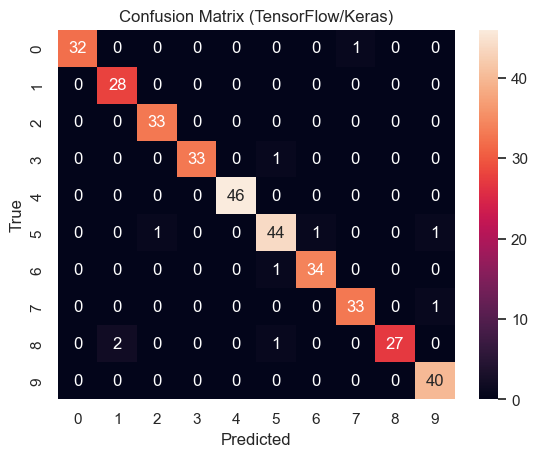

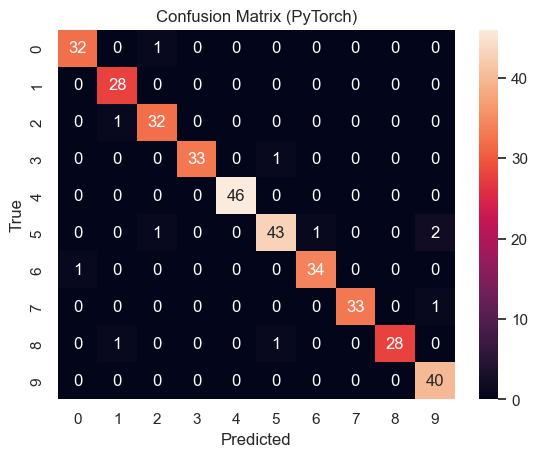

In [580]:
sns.heatmap(confusion_tf, annot=True, fmt='d')
plt.title('Confusion Matrix (TensorFlow/Keras)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
sns.heatmap(confusion_pt, annot=True, fmt='d')
plt.title('Confusion Matrix (PyTorch)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Experiment

In [586]:
# Experiment with alternative hyperparameters, additional layers, or different optimizers to see how each change impacts performance.
# Experiment with different hyperparameters in TensorFlow/Keras
model_tf_experiment = keras.Sequential([
    layers.Input(shape=(64,)),
    layers.Dense(256, activation='relu'),  # Increased number of neurons
    layers.Dropout(0.5),  # Added dropout layer for regularization
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
# Compile the model with a different optimizer
model_tf_experiment.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the experimental model
history_tf_experiment = model_tf_experiment.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)
# Evaluate the experimental model
test_loss_exp, test_accuracy_exp = model_tf_experiment.evaluate(X_test, y_test)
print(f"TensorFlow/Keras Experimental Test Accuracy: {test_accuracy_exp:.4f}")
# Compare with the original model
print(f"Original TensorFlow/Keras Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3291 - loss: 2.0674 - val_accuracy: 0.8472 - val_loss: 0.8773
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8193 - loss: 0.8020 - val_accuracy: 0.9139 - val_loss: 0.3199
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9090 - loss: 0.3970 - val_accuracy: 0.9333 - val_loss: 0.2196
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9295 - loss: 0.2923 - val_accuracy: 0.9528 - val_loss: 0.1677
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9239 - loss: 0.2428 - val_accuracy: 0.9583 - val_loss: 0.1374
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9457 - loss: 0.1919 - val_accuracy: 0.9583 - val_loss: 0.1197
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9464 - loss: 0.1735 - val_accuracy: 0.9667 - val_loss: 0.1184
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9580 - loss: 0.1593 - val_accuracy: 0.9694 - val_loss:

## Conclusion

Between "TensorFlow/Keras Test Accuracy: 0.9722" and "PyTorch Test Accuracy: 0.9694", the TensorFlow/Keras model is marginally better in terms of test accuracy.

Analysis:
* TensorFlow/Keras model has 10 misclassifications.
* PyTorch model has 11 misclassifications.

This directly aligns with the test accuracies we saw earlier:

* TensorFlow/Keras: 0.9722 (fewer errors = higher accuracy)
* PyTorch: 0.9694 (more errors = lower accuracy)
Therefore, based on these confusion matrices, the TensorFlow/Keras model is marginally better as it made one fewer misclassification on the test set.

While the difference is very small, the TensorFlow/Keras model demonstrated slightly superior performance by misclassifying fewer samples overall.

Experiment:

TensorFlow/Keras Experimental Model achieved a Test Accuracy of 0.9778.
The Original TensorFlow/Keras Model had a Test Accuracy of 0.9722.

This means that my experiment with alternative hyperparameters, and additional layers has yielded a positive improvement in test accuracy.